In this model we will use a latent factors model, a popular approach to [collaborative filtering](https://en.wikipedia.org/wiki/Collaborative_filtering#:~:text=In%20the%20newer%2C%20narrower%20sense,from%20many%20users%20(collaborating).

We will be using a truncated [SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition), because unlike a standard SVD, a truncated SVD produces a factorization where the number of columns can be specifies for a number of truncation, saving memory and processing power.

The sk-learn package has a module to build a truncated SVD. 

In [12]:
import pandas as pd
import numpy as np
import pickle

from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [5]:
#Read in data from a pickle file
df = pd.read_pickle("beer_data.pickle")

#Shorten the dataset for testing purposes
df = df.head(500000)

We create a sparse pivot table which groups together the data in a meaningful way so we can train it later.
In this case, we want out pivot table to contain the users, the item they rated, and the rating value. The rest of the values will be filled with 0s.

In [6]:
# create a sparse pivot table
df_pivot = df.pivot_table(index='review_profilename', columns='beer_name', values='review_overall').fillna(0)

beer_name,"""100"" Pale Ale","""33"" Export","""76"" Anniversary Ale","""76"" Anniversary Ale With English Hops","""Fade To Black"" Porter","""Great Satchmo"" Stout","""Jessica & Brendan's"" Bridal Ale","""Just One More"" Scotch Ale","""Nein Toll Bier"" German Alt","""O Smokey Night""",...,Über Pils,ÜberSun (Imperial Summer Wheat Beer),à L'Agave Et Au Citron Vert,überPils,Świąteczne,Švyturys Nefiltruotas Raw,Žamberecký Kanec 14°,Žamberecký Kanec Imperial Stout,横須賀ビアサケ (Yokosuka Biasake),葉山ビール (Hayama Beer)
review_profilename,,,,,,,,,,,,,,,,,,,,,
0110x011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
03SVTCobra,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
04101Brewer,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
05Harley,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0runkp0s,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Next we need to determine the number of components we want to use for our truncated SVD.

We decide this value by using Catell's [scree test](https://en.wikipedia.org/wiki/Scree_plot). We'll plot the eigenvalues of different component values, and determine the number of components that would best suit our TSVD.

In [21]:
T = df_pivot.values.T
T.shape

(17578, 22373)

In [25]:
def explained_variance(list_n_components):
    
    out = []
    
    for num in list_n_components:
        SVD = TruncatedSVD(n_components=num,random_state=num)
        SVD.fit_transform(T)
        evar = np.sum(SVD.explained_variance_ratio_)
        t = (num,evar)
        out.append(t)
    
    return out

In [35]:
n = [50,100,150,200,250,300,400,600,700,1000,1200,1400,1500]
exp_var = explained_variance(n)

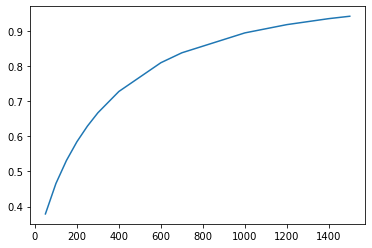

In [36]:
x,y = zip(*exp_var)
plt.plot(x, y)

Looking at the plot, we see that the number of components starts to level off at around 600 components.

So, we will create a TSVD with 600 components.

In [53]:
SVD = TruncatedSVD(n_components=600,random_state=600)
matrix = SVD.fit_transform(T)

In [54]:
#Create the correlation matrix
corr = np.corrcoef(matrix)

In [55]:
#Put all the beer names in a list
beer_names = df_pivot.columns
beer_names_list = list(beer_names)

In [61]:
#Takes in the name of the beer and returns the top n nunber of recommended beers

def beer_recs(beer_name, n):

    beer_idx = beer_names_list.index(beer_name)
    
    sim_idx = corr[beer_idx] #Get the similararity index of the input beer

    #Create a list of tuples (beer name, correlation coefficient)
    similar = []    
    for idx, coeff in enumerate(sim_idx):
        similar.append((beer_names_list[idx],coeff))
    
    similar.sort(key=lambda x: x[1], reverse=True)
    
    out = []
    
    for i in range(1,n+1):
        out.append(similar[i][0])
        
    return out

In [62]:
beer_recs('One Hop Wonder Version 12',5)

['Barrel Aged Farmhouse IPA',
 'Lift Ticket Winter Ale',
 'Nemesis Strong Ale',
 'One Hop Wonder Version 12',
 'The Ascent']

In [63]:
beer_recs('Lift Ticket Winter Ale',5)

['Lift Ticket Winter Ale',
 'Nemesis Strong Ale',
 'One Hop Wonder Version 12',
 'The Ascent',
 'Cask Pale']

In [64]:
beer_recs('Totem Pale',5)

['Tamerlane Brown Porter',
 'Mild Thing',
 'Mt. Takhoma Blonde Ale',
 "Hale's Special Bitter",
 'Second Sight Strong Scotch Ale']

In [65]:
beer_recs('Coors',5)

['Keystone Ice',
 'Old Milwaukee Beer',
 'Aspen Edge',
 'Lone Star Beer',
 'Heineken Premium Light Lager']